In [36]:
import os
import librosa
import numpy as np
import pandas as pd
import random


In [37]:
DATASET_PATH = "UrbanSound8K"

metadata_path = os.path.join(DATASET_PATH, "metadata", "UrbanSound8K.csv")
metadata = pd.read_csv(metadata_path)

print(metadata.head())


      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


In [38]:

class Clip:
    """
    Objeto que representa un clip individual del UrbanSound8K.
    Emula el estilo de soundata:

    - clip.audio -> (y, sr)
    - clip.class_label
    - clip.class_id
    - clip.fold
    - clip.file_path
    """
    def __init__(self, clip_id, audio, sr, class_label, class_id, fold, file_path):
        self.clip_id = clip_id
        self.audio = (audio, sr)
        self.class_label = class_label
        self.class_id = class_id
        self.fold = int(fold)
        self.file_path = file_path

    def __repr__(self):
        return (
            f"Clip(id={self.clip_id}, class='{self.class_label}', "
            f"class_id={self.class_id}, fold={self.fold})"
        )


class UrbanSound8KDataset:
    """
    Dataset wrapper para UrbanSound8K que imita el comportamiento de soundata.

    Atributos principales:
    - metadata: DataFrame con todo el CSV
    - clip_ids: lista de IDs de clip (índices del DataFrame)
    - folds: dict {fold: DataFrame filtrada}

    Métodos principales:
    - get_clip(clip_id) -> Clip
    - choice_clip() -> Clip aleatorio
    """

    def __init__(self, base_path="UrbanSound8K", sr=22050):
        self.base_path = base_path
        self.sr = sr

        # Cargar metadata
        metadata_path = os.path.join(base_path, "metadata", "UrbanSound8K.csv")
        if not os.path.exists(metadata_path):
            raise FileNotFoundError(
                f"No se encontró el archivo de metadata en: {metadata_path}"
            )

        self.metadata = pd.read_csv(metadata_path)

        # Limpiar posibles espacios en nombres de columnas
        self.metadata.columns = self.metadata.columns.str.strip()

        # IDs de clips (usamos el índice del DataFrame como ID)
        self.clip_ids = list(self.metadata.index)

        # Precomputar folds 1..10
        self.folds = {
            fold: self.metadata[self.metadata["fold"] == fold]
            for fold in range(1, 11)
        }

    def get_clip(self, clip_id):
        """
        Devuelve un objeto Clip, cargando el audio desde disco.

        clip_id debe ser un índice válido de self.metadata (0..len-1).
        """
        if clip_id not in self.clip_ids:
            raise ValueError(f"clip_id {clip_id} no es válido.")

        row = self.metadata.loc[clip_id]

        fold = int(row["fold"])
        filename = row["slice_file_name"]
        class_label = row["class"]
        class_id = int(row["classID"])

        audio_path = os.path.join(self.base_path, "audio", f"fold{fold}", filename)

        if not os.path.exists(audio_path):
            raise FileNotFoundError(
                f"No se encontró el archivo de audio en: {audio_path}"
            )

        # Cargar audio como mono, remuestreado a self.sr
        audio, sr = librosa.load(audio_path, sr=self.sr, mono=True)

        return Clip(
            clip_id=clip_id,
            audio=audio,
            sr=sr,
            class_label=class_label,
            class_id=class_id,
            fold=fold,
            file_path=audio_path,
        )

    def choice_clip(self):
        """Devuelve un Clip aleatorio del dataset."""
        cid = random.choice(self.clip_ids)
        return self.get_clip(cid)

    def __len__(self):
        return len(self.clip_ids)

    @property
    def num_clips(self):
        return len(self.clip_ids)

    def __repr__(self):
        return f"UrbanSound8KDataset(num_clips={len(self)}, folds=10)"


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Parámetros globales que usaremos luego
SR = 22050       # sample rate fijo
DURATION = 4.0   # duración objetivo en segundos
N_MFCC = 40      # número de coeficientes MFCC

dataset = UrbanSound8KDataset("UrbanSound8K", sr=SR)
example_clip = dataset.choice_clip()


print("TensorFlow:", tf.__version__)

# Revisar el ejemplo que ya cargaste
y, sr = example_clip.audio
print("Shape del audio:", y.shape)
print("Sample rate original:", sr)
print("Clase (label):", example_clip.class_label)
print("Fold:", example_clip.fold)


TensorFlow: 2.20.0
Shape del audio: (29327,)
Sample rate original: 22050
Clase (label): gun_shot
Fold: 10


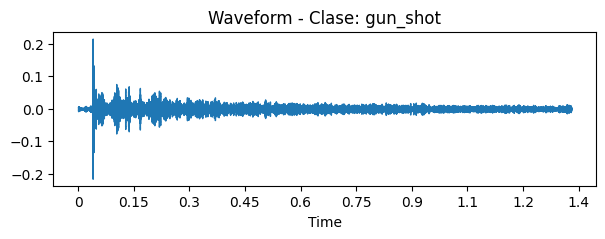

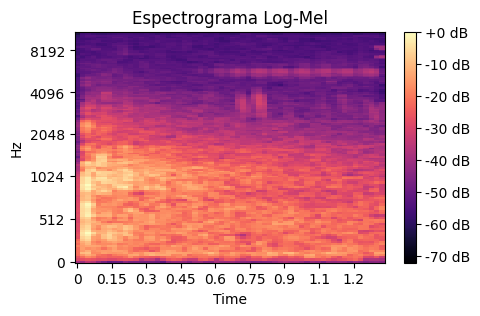

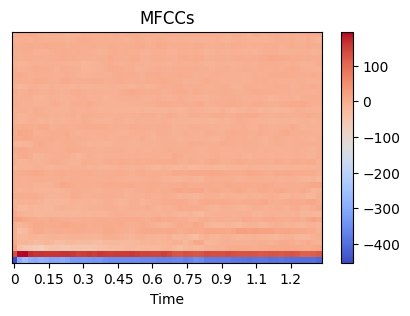

In [40]:
# Visualizar la forma de onda
plt.figure(figsize=(7, 2))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform - Clase: {example_clip.class_label}")
plt.show()

# Visualizar el espectrograma log-mel
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(5, 3))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Espectrograma Log-Mel")
plt.show()

# Visualizar los MFCCs
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

plt.figure(figsize=(5, 3))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.colorbar()
plt.title("MFCCs")
plt.show()


In [41]:
def load_and_fix_audio(file_path, sr=SR, duration=DURATION):
    """
    Carga el audio, lo convierte en mono, lo re-muestrea y asegura duración fija
    """
    # carga audio con librosa
    y, original_sr = librosa.load(file_path, sr=sr, mono=True)

    # duración objetivo en samples
    target_len = int(sr * duration)

    # si es más largo -> recortar
    if len(y) > target_len:
        y = y[:target_len]

    # si es más corto -> padding con ceros
    if len(y) < target_len:
        pad_width = target_len - len(y)
        y = np.pad(y, (0, pad_width), mode='constant')

    return y


In [42]:
def extract_mfcc_features(y, sr=SR, n_mfcc=N_MFCC):
    """
    Extrae MFCCs y devuelve un arreglo de tamaño (n_mfcc, T)
    """
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc


In [43]:
def process_clip(clip):
    """
    Recibe un clip de soundata y devuelve:
    - MFCCs del audio ya normalizado
    - label (class_id)
    """
    file_path = clip.file_path
    y = load_and_fix_audio(file_path)
    mfcc = extract_mfcc_features(y)
    label = clip.class_id
    return mfcc, label


In [44]:
def load_dataset_by_folds(dataset, folds):
    X = []
    Y = []
    for clip_id in dataset.clip_ids:
        clip = dataset.get_clip(clip_id)
        if clip.fold in folds:
            mfcc, label = process_clip(clip)
            X.append(mfcc)
            Y.append(label)
    return np.array(X), np.array(Y)



In [45]:
def load_data_for_fold(dataset, test_fold):
    train_folds = [f for f in range(1, 11) if f != test_fold]

    X_train, y_train = load_dataset_by_folds(dataset, train_folds)
    X_test,  y_test  = load_dataset_by_folds(dataset, [test_fold])

    print(f"Fold {test_fold}: train={train_folds}, test={test_fold}")
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

    return X_train, y_train, X_test, y_test


In [46]:
def prepare_mlp_features(X):
    """
    Recibe X con forma (num_samples, n_mfcc, T)
    Devuelve X_mlp con forma (num_samples, n_mfcc)
    """
    X_out = []
    for mfcc in X:
        # promedio sobre tiempo → vector de 40
        vec = np.mean(mfcc, axis=1)
        X_out.append(vec)
    return np.array(X_out)


In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_mlp_model(input_dim, num_classes=10):
    """
    Construye un modelo MLP simple para clasificación de MFCC promediados.
    """
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),

        Dense(128, activation='relu'),
        Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [48]:
from sklearn.preprocessing import StandardScaler
import numpy as np

fold_accuracies = []   # aquí guardamos los accuracies de cada fold

for test_fold in range(1, 11):   # folds 1 → 10
    print("===================================================")
    print(f"🚀 Ejecutando Fold {test_fold} ...")
    print("===================================================")

    # 1. Cargar MFCC crudos (40, T)
    X_train_raw, y_train, X_test_raw, y_test = load_data_for_fold(dataset, test_fold=test_fold)

    print("Shapes iniciales:")
    print("X_train_raw:", X_train_raw.shape)
    print("X_test_raw:",  X_test_raw.shape)

    # 2. Convertir MFCC (40, T) → vectores (40,)
    X_train_mlp = prepare_mlp_features(X_train_raw)
    X_test_mlp  = prepare_mlp_features(X_test_raw)

    print("Shapes después de promedio temporal:")
    print("X_train_mlp:", X_train_mlp.shape)
    print("X_test_mlp:",  X_test_mlp.shape)

    # 3. Normalizar
    scaler = StandardScaler()
    X_train_mlp = scaler.fit_transform(X_train_mlp)
    X_test_mlp  = scaler.transform(X_test_mlp)

    # 4. Crear modelo MLP
    input_dim = X_train_mlp.shape[1]
    mlp_model = build_mlp_model(input_dim=input_dim)

    # 5. Entrenar
    history = mlp_model.fit(
        X_train_mlp, y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_test_mlp, y_test),
        verbose=1
    )

    # 6. Evaluar
    test_loss, test_acc = mlp_model.evaluate(X_test_mlp, y_test, verbose=0)
    print(f"\n🎯 Accuracy del Fold {test_fold}: {test_acc:.4f}\n")

    fold_accuracies.append(test_acc)


# ===============================
# RESULTADOS FINALES DEL CV
# ===============================

acc_mean = np.mean(fold_accuracies)
acc_std  = np.std(fold_accuracies)

print("===================================================")
print("🔵 RESULTADOS DEL 10-FOLD CROSS VALIDATION (MLP)")
print("===================================================")
print("Accuracies por fold:", fold_accuracies)
print(f"\n📌 Accuracy promedio:      {acc_mean:.4f}")
print(f"📌 Desviación estándar:    {acc_std:.4f}")
print("===================================================")


🚀 Ejecutando Fold 1 ...
Fold 1: train=[2, 3, 4, 5, 6, 7, 8, 9, 10], test=1
Train size: 7859, Test size: 873
Shapes iniciales:
X_train_raw: (7859, 40, 173)
X_test_raw: (873, 40, 173)
Shapes después de promedio temporal:
X_train_mlp: (7859, 40)
X_test_mlp: (873, 40)


c:\Users\Devlepa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4746 - loss: 1.5025 - val_accuracy: 0.4960 - val_loss: 1.7627
Epoch 2/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6564 - loss: 1.0157 - val_accuracy: 0.4983 - val_loss: 1.8635
Epoch 3/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7183 - loss: 0.8406 - val_accuracy: 0.4834 - val_loss: 2.0525
Epoch 4/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7487 - loss: 0.7373 - val_accuracy: 0.5017 - val_loss: 2.2258
Epoch 5/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7785 - loss: 0.6649 - val_accuracy: 0.4914 - val_loss: 2.3115
Epoch 6/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7954 - loss: 0.6091 - val_accuracy: 0.5063 - val_loss: 2.4109
Epoch 7/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8163 - loss: 0.5497 - val_accuracy: 0.5132 - val_loss: 2.4366
Epoch 8/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8250 - loss: 0.5177 - val_accuracy: 0

c:\Users\Devlepa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4707 - loss: 1.5259 - val_accuracy: 0.4561 - val_loss: 1.6104
Epoch 2/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6453 - loss: 1.0456 - val_accuracy: 0.4730 - val_loss: 1.6261
Epoch 3/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7053 - loss: 0.8762 - val_accuracy: 0.4910 - val_loss: 1.5860
Epoch 4/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7449 - loss: 0.7712 - val_accuracy: 0.5101 - val_loss: 1.6742
Epoch 5/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7780 - loss: 0.6750 - val_accuracy: 0.5056 - val_loss: 1.7649
Epoch 6/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7914 - loss: 0.6154 - val_accuracy: 0.5113 - val_loss: 1.9365
Epoch 7/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8116 - loss: 0.5659 - val_accuracy: 0.4910 - val_loss: 1.9555
Epoch 8/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8265 - loss: 0.5115 - val_accuracy: 0.4921 - val_

KeyboardInterrupt: 